In [2]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [17]:
n = 128
m = 64
sigma = 0.1
p = 0.05
num_itr = 40

K = 200
adam_lr = 5e-5
max_inner = 20

A = np.random.randn(m, n)
eig, _ = LA.eig(A.T @ A)
gamma_opt = 1./max(eig)
A = jnp.array(A)

In [18]:
def mini_batch(K):
    seq = np.random.randn(n, K)
    support = np.random.binomial(1,p,size=(n, K))
    x = jnp.array(seq * support)
    y = A @ x + sigma * jnp.array(np.random.randn(m, K))
    return y, x

In [19]:
def softshrink(x, lam):
    return jnp.sign(x) * jnp.max(jnp.append(jnp.abs(x) - lam, 0))
vec_softshrink = jax.jit(jax.vmap(softshrink, in_axes=[-1, None], out_axes=-1))

In [47]:
def ISTA(max_itr, y):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= gamma_opt * A.T @ (A@x - y)
        x = vec_softshrink(x.reshape(1, -1), gamma_opt)
        x = x.reshape(n, K)
    return x

In [48]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [51]:
def comp_mse(max_itr):
    y, x_org = mini_batch(K)
    x_hat = ISTA(max_itr, y)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [71]:
ISTA_mse = [float(jax.device_get(comp_mse(i+1)).real) for i in range(num_itr)]
df = pd.DataFrame()
df["Itaration"] = range(num_itr)
df["ISTA (fixed step size)"] = ISTA_mse

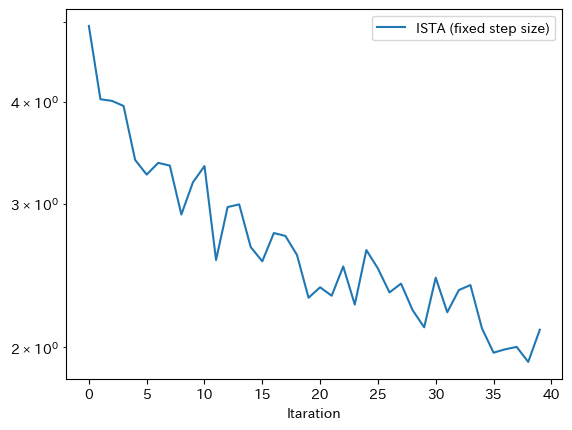

In [73]:
df.plot(x = df.columns[0], y = df.columns[1])
plt.yscale("log")